Population predictor
=============

Using Deep Learning
------------

The following things are being done here.
1. Load dataset.npy file for the TPM count from quant.sf file. If not present:
    a. Read from the quant.sf files to a numpy array dataset.
    b. Save it using numpy.save file for faster access.
2. Perform Dimensionality reduction. Possible methods:
    a. PCA (Problems: Not for dataset with number of features larger than number of samples).
    b. TSNE (Slow)
    c. Encoder (Deep learning approach to encode into a lower dimensional form)
3. Apply the model to this reduced feature vector. Possible models:
    a. Fully connected neural network with softmax loss.
    b. Conv1D
    c. ...

In [190]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import yadlt
from sklearn.model_selection import train_test_split
import pickle

Read the input from the quant.sf file.

In [2]:
# Read the CSV file to map samples vs labels.
data_frame = pd.read_csv('p1_train.csv')
labels = sorted(list(set(data_frame['label'])))

num_of_transcripts = 199324
num_of_samples = data_frame.shape[0]
num_labels = len(labels)

dataset = np.empty((num_of_samples, num_of_transcripts), dtype=np.float32)
sample_vs_label = np.empty(num_of_samples, dtype='int')
samples = np.empty(num_of_samples, dtype='<U9')

for index, row in data_frame.iterrows():
    if(index >= num_of_samples): break
    sample_vs_label[index] = labels.index(row['label'])
    samples[index] = row['accession']
print(sample_vs_label)

[0 1 0 0 1 2 3 2 1 2 2 4 4 2 2 3 3 0 0 2 1 3 2 2 4 0 0 4 1 4 0 1 2 4 4 3 3
 2 0 2 2 1 1 1 3 4 1 3 4 3 4 0 2 4 0 4 4 2 3 2 2 1 4 3 2 1 4 0 3 3 4 0 0 4
 0 4 3 0 0 0 0 2 0 2 0 1 1 3 1 0 0 2 1 3 3 2 0 3 4 4 2 3 0 2 1 4 4 3 4 4 1
 0 3 3 1 1 2 1 1 1 4 3 3 1 0 0 3 0 1 3 3 0 3 2 0 0 1 3 1 2 4 3 4 1 3 4 3 1
 4 3 2 0 0 4 3 2 1 3 0 1 2 0 3 3 2 1 4 4 1 1 1 3 3 3 2 4 3 3 0 0 2 1 1 0 1
 1 4 0 0 2 0 3 4 3 1 2 3 0 2 2 2 0 3 4 3 3 4 3 0 4 4 2 3 1 1 3 1 3 0 4 0 1
 4 1 3 2 4 0 2 2 1 4 2 1 0 1 4 4 3 4 1 4 1 1 1 1 1 1 1 0 4 2 2 4 3 0 0 4 0
 3 2 4 2 2 4 3 3 3 1 0 2 0 1 0 0 4 2 2 3 4 0 2 4 0 0 0 1 2 3 4 2 4 4 2 1 2
 0 2 2 4 3 3 3 2 2 4 1 3 1 4 3 2 1 4 4 4 2 4 1 2 0 3 1 1 0 3 1 2 2 3 2 1 4
 0 1 4 2 4 0 1 4 0 3 2 2 2 1 1 0 1 0 1 2 0 2 1 4 3 2 1 2 2 2 1 2 4 3 0 0]


Try and read from any saved 'dataset.npy' file. If present then load it to numpy array dataset, else just read it from all possible folders.

In [3]:
% % time
if (os.path.isfile('dataset.npy')):
    dataset = np.load('dataset.npy')
else:
    TRAIN_PATH = './train/'
    # Read the 'quant.sf' value here for each sample.
    for i in range(num_of_samples):
        if i % 20 == 0: print(i)
        file_name = TRAIN_PATH + samples[i] + '/bias/quant.sf'
        quant_sf = np.genfromtxt(file_name, delimiter='\t', usecols=3, skip_header=True, dtype=np.float32)
        dataset[i] = quant_sf

    # Using https://i.stack.imgur.com/4d6yo.png to judge the best way to save the dataset as a npy file
    # for faster reloading of numpy array.
    np.save('dataset.npy', dataset)


CPU times: user 1.28 ms, sys: 256 ms, total: 258 ms
Wall time: 487 ms


In [4]:
def reformat(labels):
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return labels
print(sample_vs_label[:5])
sample_vs_label = reformat(sample_vs_label)
print(sample_vs_label[:5])

[0 1 0 0 1]
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]]


In [5]:
train_data, test_data, train_data_label, test_data_label = train_test_split(dataset,\
                                                                                          sample_vs_label, \
                                                                                          test_size=0.2)

# Tree-based feature selection

Tree-based estimators (see the sklearn.tree module and forest of trees in the sklearn.ensemble module) can be used to compute feature importances, which in turn can be used to discard irrelevant features (when coupled with the sklearn.feature_selection.SelectFromModel meta-transformer):

In [6]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler = StandardScaler().fit(train_data)
train_sample = scaler.transform(train_data)

clf = ExtraTreesClassifier()
clf = clf.fit(train_sample, train_data_label)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
train_sample = model.transform(train_sample)
train_sample.shape

with open('scaler.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('tree_based_model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [8]:
train_sample.shape

(295, 831)

# Neural Network
## FC Connected layer
Using a 2-layer fully connected neural network of 128, 64 relu neurons with batch size of 8

In [278]:
batch_size = 50
num_hidden_nodes = [800, 10]
num_of_transcripts = train_sample.shape[1]
input_size = [num_of_transcripts]+num_hidden_nodes
num_layers = len(num_hidden_nodes)

graph = tf.Graph()
with graph.as_default():
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, shape=
                                     (batch_size, num_of_transcripts))
    tf_train_labels = tf.placeholder(tf.float32, shape=
                                    (batch_size, num_labels))
    tf_test_data = tf.placeholder(tf.float32, shape=
                                    (None, num_of_transcripts))
    print(tf_test_data.shape)
    global_step = tf.Variable(0)
    
    # Weights
    weights1 = []
    biases1 = []
    beta1 = []
    
    for i in range(num_layers):
        weights1.append(tf.Variable(tf.truncated_normal([input_size[i], num_hidden_nodes[i]],\
                                                        stddev=np.sqrt(2.0 / (input_size[i])))))
        biases1.append(tf.Variable(tf.zeros([num_hidden_nodes[i]])))
        beta1.append(1e-3)
    biases2 = tf.Variable(tf.zeros([num_labels]))
    weights2 = tf.Variable(tf.truncated_normal([input_size[-1], num_labels],\
                                               stddev=np.sqrt(2.0 / input_size[-1])))
    beta2 = 1e-3
    
    # Training Computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1[0]) + biases1[0])
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    for i in range(1, num_layers):
        print(lay1_train.shape)
        lay1_train = tf.nn.relu(tf.matmul(drop1, weights1[i]) + biases1[i])
        drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))\
                           + beta2 * tf.nn.l2_loss(weights2)
    for i in range(num_layers):
        loss += beta1[i] * tf.nn.l2_loss(weights1[i]) 
    
    # Optimizer
    learning_rate = tf.train.exponential_decay(1e-4, global_step, 1e6, 0.65, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
                           
    lay1_test = tf.nn.relu(tf.matmul(tf_test_data, weights1[0]) + biases1[0])
    for i in range(1, num_layers):
        lay1_test = tf.nn.relu(tf.matmul(lay1_test, weights1[i]) + biases1[i])
    logits_test = tf.matmul(lay1_test, weights2) + biases2
    test_prediction = tf.nn.softmax(logits_test)
    

(?, 831)
(50, 800)


# Running the neural net
## Training for 2000 epochs

In [279]:
num_steps = 1000
result = np.zeros(4, dtype=np.float32)
i = 0
accuracy_val = []
minibatch = list()
validation = list()
steps = list()
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    print('Initialised')
    skf = KFold(n_splits=4)
    for train_index, valid_index in skf.split(train_sample, train_data_label):
        train_dataset, valid_dataset = train_sample[train_index], train_sample[valid_index]
        train_labels, valid_labels = train_data_label[train_index], train_data_label[valid_index]

        minibatch.append(list())
        validation.append(list())
        steps.append(list())
        #     train_dataset = train_sample
        #     train_labels = train_data_label
        for step in range(num_steps):
            offset = (step * batch_size) % \
                     (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:offset + batch_size, :]
            batch_labels = train_labels[offset:offset + batch_size, :]

            feed_dict = {tf_train_dataset: batch_data, \
                         tf_train_labels: batch_labels}
            _, l, predictions = session.run([optimizer, loss, \
                                             train_prediction], feed_dict=feed_dict)
            if step % int(num_steps / 10) == 0:
                #                 print("Minibatch accuracy: %.1f%% " % accuracy(predictions, batch_labels))
                minibatch[-1].append(accuracy(predictions, batch_labels))
                #                 print("Validation accuracy %d: %.1f%% " % (step, accuracy(test_prediction.eval(feed_dict={tf_test_data : valid_dataset}), valid_labels)))
                validation[-1].append(
                    accuracy(test_prediction.eval(feed_dict={tf_test_data: valid_dataset}), valid_labels))
                steps[-1].append(step)
        result[i] = accuracy(test_prediction.eval(feed_dict={tf_test_data: valid_dataset}), valid_labels)
        #         print("Validation accuracy: %.1f%%" % result[i])
        i += 1

    save_path = saver.save(session, "./model.ckpt")
    print("Model saved in file: %s" % save_path)
    print("Mean result: %.1f%%" % np.mean(result))


Initialised
Model saved in file: ./model.ckpt
Mean result: 91.9%


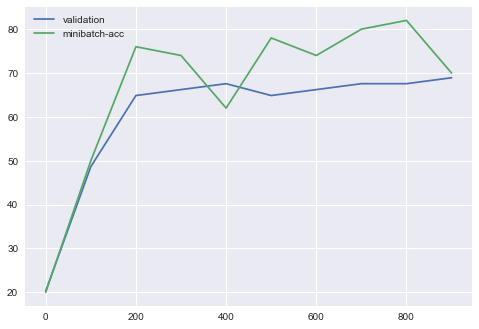

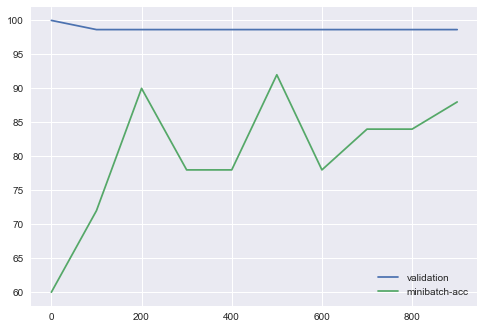

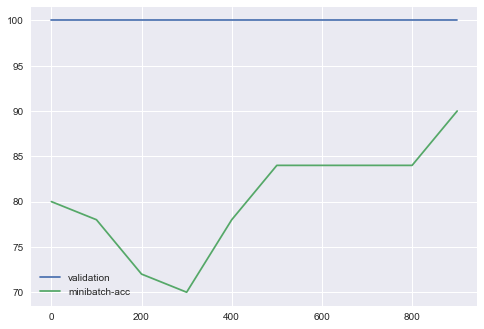

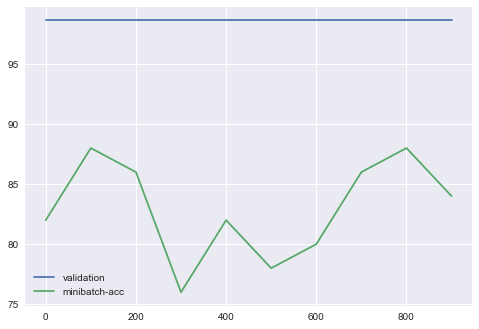

In [280]:
for idx in range(i):
    p = plt.figure()
    plt.plot(steps[idx], validation[idx], label='validation')
    plt.plot(steps[idx], minibatch[idx], label='minibatch-acc')
    plt.legend()
    plt.show()

# Test Prediction

In [281]:
with open('scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
with open('tree_based_model.pickle', 'rb') as handle:
    model = pickle.load(handle)

test_sample = scaler.transform(test_data)
test_sample = model.transform(test_sample)

In [282]:
print(np.std(test_sample))
print(np.std(train_sample))

1.05299
1.0


In [283]:
with tf.Session(graph=graph) as session:
    # Restore variables from disk.
    saver.restore(session, "./model.ckpt")
    print("Model restored.")
    print("Test accuracy: %.1f%%" % \
          accuracy(test_prediction.eval(feed_dict={tf_test_data : test_sample}), test_data_label))

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
Test accuracy: 81.1%
